# The Agate Tutorial

The best way to learn to use any tool is to actually use it. In this tutorial we will use agate to answer some basic questions about a dataset.

The data we will be using is a copy of the [National Registry of Exonerations]( https://www.law.umich.edu/special/exoneration/Pages/detaillist.aspx) made on August 28th, 2015. This dataset lists individuals who are known to have been exonerated after having been wrongly convicted in United States courts. At the time this data was copied there were 1,651 entries in the registry.

## Installing agate

Installing agate from the command line is easy:

    pip install agate

Note: You should be installing agate inside a [virtualenv](https://virtualenv.readthedocs.io/en/stable/>). If for some crazy reason you aren't using virtualenv you will need to add a ``sudo`` to the previous command.*

For more detailed installation instructions, see the [Installation](https://agate.readthedocs.io/en/latest/install.html) section of the documentation.

## Getting the data

If you're just reading this tutorial you can skip this section. If you want to try working through it on your own then you'll need to download the data.

It can be downloaded from

    curl -L -O https://github.com/wireservice/agate/raw/master/examples/realdata/exonerations-20150828.csv

The rest of this tutorial will expect that data to be located in `examples/realdata`.

## Importing agate

Let's get started!

In [1]:
import agate

## Loading data from a CSV

The [`Table`](https://agate.readthedocs.io/en/latest/api/table.html#module-agate.table) is the basic class in agate. To create a table from a CSV we use the [`Table.from_csv`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.from_csv) class method:

In [2]:
exonerations = agate.Table.from_csv('examples/realdata/exonerations-20150828.csv')

With no other arguments specified, agate will automatically create an instance of [`TypeTester`](https://agate.readthedocs.io/en/latest/api/type_tester.html#agate.TypeTester) and use it to figure out the type of each column. TypeTester is a "best guess" approach to determining the kinds of data in your table. It can guess wrong. In that case you can create a TypeTester manually and use the ``force`` argument to override its guess for a specific column:

In [3]:
tester = agate.TypeTester(force={
    'false_evidence': agate.Boolean()
})

exonerations = agate.Table.from_csv('examples/realdata/exonerations-20150828.csv', column_types=tester)

If you already know the types of your data you may wish to skip the TypeTester entirely. You may pass sequences of column names and column types to [`Table.from_csv`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.from_csv) as the ``column_names`` and ``column_types`` arguments, respectively.

For larger datasets the [`TypeTester`](https://agate.readthedocs.io/en/latest/api/type_tester.html#agate.TypeTester) can be slow to evaluate the data. In that case you can specify a `limit` argument to restrict the amount of data it will use to infer types:

In [4]:
tester = agate.TypeTester(limit=100)

exonerations = agate.Table.from_csv('examples/realdata/exonerations-20150828.csv', column_types=tester)

The dataset we are using in this tutorial is simple enough that we can rely on the built-in TypeTester to guess quickly and accurately.

**Note:** agate's CSV reader and writer support unicode and other encodings for both Python 2 and Python 3. Try using them as a drop-in replacement for Python's builtin module: `from agate import csv`.

**Note:** agate also has [`Table.from_json`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.from_json) for creating tables from JSON data.

Describing the table
====================

If you're working with new data, or you just need a refresher, you may want to review what columns are in the table. You can do this with the [`.Table.print_structure`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.print_structure) method or by just calling `print` on the table:

In [5]:
print(exonerations)

| column              | data_type |
| ------------------- | --------- |
| last_name           | Text      |
| first_name          | Text      |
| age                 | Number    |
| race                | Text      |
| state               | Text      |
| tags                | Text      |
| crime               | Text      |
| sentence            | Text      |
| convicted           | Number    |
| exonerated          | Number    |
| dna                 | Boolean   |
| dna_essential       | Text      |
| mistake_witness     | Boolean   |
| false_confession    | Boolean   |
| perjury             | Boolean   |
| false_evidence      | Boolean   |
| official_misconduct | Boolean   |
| inadequate_defense  | Boolean   |



Navigating table data
=====================

agate goes to great pains to make accessing the data in your tables work seamlessly for a wide variety of use-cases. Access by both [`Column`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.Column) and [`Row`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.Row) is supported, via the [`Table.columns`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.columns) and [`Table.rows`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.rows) attributes respectively.

All four of these objects are examples of [`.MappedSequence`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.MappedSequence), the foundational type that underlies much of agate's functionality. A MappedSequence functions very similar to a standard Python [`dict`](https://docs.python.org/3/tutorial/datastructures.html#dictionaries), with a few important exceptions:

* Data may be accessed either by numeric index (e.g. column number) or by a non-integer key (e.g. column name).
* Items are ordered, just like an instance of [`collections.OrderedDict`](https://docs.python.org/3/library/collections.html#collections.OrderedDict).
* Iterating over the sequence returns its *values*, rather than its *keys*.

To demonstrate the first point, these two lines are both valid ways of getting the first column in the `exonerations` table:

In [6]:
exonerations.columns['last_name']

In [7]:
exonerations.columns[0]

In the same way, rows can be accessed either by numeric index or by an optional, unique "row name" specified when the table is created. In this tutorial we won't use row names, but here is an example of how they work:

In [8]:
exonerations = agate.Table.from_csv('examples/realdata/exonerations-20150828.csv', row_names=lambda r: '%(last_name)s, %(first_name)s' % (r))

exonerations.rows[0]

In [9]:
exonerations.rows['Abbitt, Joseph Lamont']

In this case we create our row names using a [`lambda`](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) function that takes a row and returns an unique identifer. If your data has a unique column, you can also just pass the column name. (For example, a column of USPS abbrevations or FIPS codes.) Note, however, that your row names can never be `int`, because that is reserved for indexing by numeric order. (A [`decimal.Decimal`](https://docs.python.org/3/library/decimal.html#decimal.Decimal) or stringified integer is just fine.)

Once you've got a specific row, you can then access its individual values (cells, in spreadsheet-speak) either by numeric index or column name:

In [10]:
row = exonerations.rows[0]

row[0]

'Abbitt'

In [11]:
row['last_name']

'Abbitt'

And the same goes for columns, which can be indexed numerically or by row name (if one has been setup):

In [12]:
column = exonerations.columns['crime']

column[0]

'Child Sex Abuse'

In [13]:
column['Abbitt, Joseph Lamont']

'Child Sex Abuse'

For any instance of [`.MappedSequence`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.MappedSequence), iteration returns values, *in order*. Here we print only the first ten:

In [14]:
for row in exonerations.rows[:10]:
    print(row['last_name'])

Abbitt
Abdal
Abernathy
Acero
Adams
Adams
Adams
Adams
Adams
Adams


To summarize, the four most common data structures in agate ([`Column`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.Column), [`Row`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.Row), [`Table.columns`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.columns) and [`Table.rows`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.rows)) are all instances of [`MappedSequence`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.MappedSequence) and therefore all behave in a uniform way. This is also true of [`TableSet`](https://agate.readthedocs.io/en/latest/api/tableset.html), which will discuss later on.

Aggregating column data
=======================

With the basics out of the way, let's do some actual analysis. Analysis begins with questions, so let's ask some.

**Question:** How many exonerations involved a false confession?

Answering this question involves counting the number of ``True`` values in the ``false_confession`` column. When we created the table we specified that the data in this column contained [`Boolean`](https://agate.readthedocs.io/en/latest/api/data_types.html#agate.Boolean) data. Because of this, agate has taken care of coercing the original text data from the CSV into Python's ``True`` and ``False`` values.

We'll answer the question using an instance of [`Count`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Count) which is a type of [`Aggregation`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Aggregation). Aggregations are used to perform "column-wise" calculations. That is, they derive a new single value from the contents of a column. The [`Count`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Count) aggregation can count either all values in a column, or how many times a particular value appears.

An Aggregation is applied to a table using [`Table.aggregate`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.aggregate).

It sounds complicated, but it's really simple. Putting it all together looks like this:

In [15]:
exonerations.aggregate(agate.Count('false_confession', True))

211

Let's look at another example, this time using a numerical aggregation.

**Question:** What was the median age of exonerated indviduals at time of arrest?

In [16]:
exonerations.aggregate(agate.Median('age'))

/Users/cgroskopf/src/agate/agate/aggregations/median.py:37: NullCalculationWarning: Column "age" contains nulls. These will be excluded from Median calculation.


Decimal('26')

The answer to our question is "26 years old", however, as the warnings indicate, not every exonerated individual in the data has a value for the ``age`` column. The [`Median`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Median) statistical operation has no standard way of accounting for null values, so it leaves them out of the calculation.

**Question:** How many individuals do not have an age specified in the data?

Now that we know there are null values in the ``age`` column, we might worry about our sample size. What if most of the rows don't have an age?

In [17]:
exonerations.aggregate(agate.Count('age', None))

9

Only nine rows in this dataset don't have age, so it's certainly still useful to compute a median. However, we might still want to filter those rows out so we could have a consistent sample for all of our calculations. In the next section you'll learn how to do just that.

Different [`aggregations`](https://agate.readthedocs.io/en/latest/api/aggregations.html) can be applied depending on the type of data in each column. If none of the provided aggregations suit your needs you can use [`Summary`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Summary) to apply an arbitrary function to a column. If that still doesn't suit your needs you can always create your own aggregation from scratch by subclassing [`Aggregation`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Aggregation).

Selecting and filtering data
============================

So what if those rows with no age were going to flummox our analysis? Agate's [`Table`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table) class provides a full suite of SQL-like operations including [`Table.select`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.select) for grabbing specific columns, [`Table.where`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.where) for selecting particular rows and [`Table.group_by`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.group_by) for grouping rows by common values.

Let's use [`Table.where`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.where) to filter our exonerations table to only those individuals that have an age specified.

In [18]:
with_age = exonerations.where(lambda row: row['age'] is not None)

You'll notice we provide a [`lambda`](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) function to the [`Table.where`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.where). This function is applied to each row and if it returns ``True``, then the row is included in the output table.

A crucial thing to understand about these table methods is that they return **new tables**. In our example above ``exonerations`` was a [`Table`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table) instance and we applied [`Table.where`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.where), so ``with_age`` is a new, different [`Table`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table). The tables themselves can't be changed. You can create new tables with these methods, but you can't modify them in-place. (If this seems weird, just trust me. There are lots of good computer science-y reasons to do it this way.)

We can verify this did what we expected by counting the rows in the original table and rows in the new table:

In [19]:
len(exonerations.rows) - len(with_age.rows)

9

Nine rows were removed, which is the number of nulls we had already identified were in the column.

Now if we calculate the median age of these individuals, we don't see the warning anymore.

In [20]:
with_age.aggregate(agate.Median('age'))

Decimal('26')

Computing new columns
=====================

In addition to "column-wise" [`aggregations`](https://agate.readthedocs.io/en/latest/api/aggregations.html#module-agate.aggregations) there are also "row-wise" [`computations`](https://agate.readthedocs.io/en/latest/api/computations.html#module-agate.computations). Computations go through a [`Table`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table) row-by-row and derive a new column using the existing data. To perform row computations in agate we use subclasses of [`Computation`](https://agate.readthedocs.io/en/latest/api/computations.html#agate.Computation).

When one or more instances of [`Computation`](https://agate.readthedocs.io/en/latest/api/computations.html#agate.Computation) are applied with the [`Table.compute`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.compute) method, a new table is created with additional columns.

**Question:** How long did individuals remain in prison before being exonerated?

To answer this question we will apply the [`Change`](https://agate.readthedocs.io/en/latest/api/computations.html#agate.Change) computation to the ``convicted`` and ``exonerated`` columns. Each of these columns contains the individual's age at the time of that event. All that [`Change`](https://agate.readthedocs.io/en/latest/api/computations.html#agate.Change) does is compute the difference between two numbers. (In this case each of these columns contain a [`Number`](https://agate.readthedocs.io/en/latest/api/data_types.html#agate.Number), but this will also work with [`Date`](https://agate.readthedocs.io/en/latest/api/data_types.html#agate.Date) or [`DateTime`](https://agate.readthedocs.io/en/latest/api/data_types.html#agate.DateTime).)

In [21]:
with_years_in_prison = exonerations.compute([
    ('years_in_prison', agate.Change('convicted', 'exonerated'))
])

with_years_in_prison.aggregate(agate.Median('years_in_prison'))

Decimal('8')

The median number of years an exonerated individual spent in prison was 8 years.

Sometimes, the built-in computations, such as [`Change`](https://agate.readthedocs.io/en/latest/api/computations.html#agate.Change) won't suffice. I mentioned before that you could perform arbitrary column-wise aggregations using [`Summary`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Summary). You can do the same thing for row-wise computations using [`Formula`](https://agate.readthedocs.io/en/latest/api/computations.html#agate.Formula). This is somewhat analogous to Excel's cell formulas.

For example, this code will create a ``full_name`` column from the ``first_name`` and ``last_name`` columns in the data:

In [22]:
full_names = exonerations.compute([
    ('full_name', agate.Formula(agate.Text(), lambda row: '%(first_name)s %(last_name)s' % row))
])

For efficiency's sake, agate allows you to perform several computations at once (though their results can't depend on one another):

In [23]:
with_computations = exonerations.compute([
    ('full_name', agate.Formula(agate.Text(), lambda row: '%(first_name)s %(last_name)s' % row)),
    ('years_in_prison', agate.Change('convicted', 'exonerated'))
])

You can also compute new columns to clean up your raw data. In the initial data, the ``state`` column has some values with a 'F-' prefix on the state abbreviation. Cases with that prefix are federal cases as opposed to state prosecutions. To make the data easier to use, we can create a new ``federal`` column to tag federal cases and clean up the original state column:

In [24]:
clean_state_data = exonerations.compute([
    ('federal', agate.Formula(agate.Boolean(), lambda row: row['state'].startswith('F-'))),
    ('state', agate.Formula(agate.Text(), lambda row: row['state'][2:] if row['state'].startswith('F-') else row['state']))
], replace=True)

We add the ``replace`` argument to our ``compute`` method to replace the state column in place.

If [`Formula`](https://agate.readthedocs.io/en/latest/api/computations.html#agate.Formula) is not flexible enough (for instance, if you needed to compute a new value based on the distribution of data in a column) you can always implement your own subclass of [`Computation`](https://agate.readthedocs.io/en/latest/api/computations.html#agate.Computation). See the API documentation for [`computations`](https://agate.readthedocs.io/en/latest/api/computations.html#module-agate.computations to see all of the supported ways to compute new data.

Sorting and slicing
===================

**Question:** Who are the ten exonerated individuals who were youngest at the time they were arrested?

Remembering that methods of tables return tables, we will use [`Table.order_by`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.order_by) to sort our table:

In [25]:
sorted_by_age = exonerations.order_by('age')

We can then use [`Table.limit`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.limit) get only the first ten rows of the data.

In [26]:
youngest_ten = sorted_by_age.limit(10)

Now let's use [`Table.print_table`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.print_table) to help us pretty the results in a way we can easily review:

In [27]:
youngest_ten.print_table(max_columns=7)

| last_name | first_name | age | race      | state | tags    | crime   | ... |
| --------- | ---------- | --- | --------- | ----- | ------- | ------- | --- |
| Murray    | Lacresha   |  11 | Black     | TX    | CV, F   | Murder  | ... |
| Adams     | Johnathan  |  12 | Caucasian | GA    | CV, P   | Murder  | ... |
| Harris    | Anthony    |  12 | Black     | OH    | CV      | Murder  | ... |
| Edmonds   | Tyler      |  13 | Caucasian | MS    |         | Murder  | ... |
| Handley   | Zachary    |  13 | Caucasian | PA    | A, CV   | Arson   | ... |
| Jimenez   | Thaddeus   |  13 | Hispanic  | IL    |         | Murder  | ... |
| Pacek     | Jerry      |  13 | Caucasian | PA    |         | Murder  | ... |
| Barr      | Jonathan   |  14 | Black     | IL    | CDC, CV | Murder  | ... |
| Brim      | Dominique  |  14 | Black     | MI    | F       | Assault | ... |
| Brown     | Timothy    |  14 | Black     | FL    |         | Murder  | ... |


If you find it impossible to believe that an eleven year-old was convicted of murder, I encourage you to read the Registry's [description of the case](https://www.law.umich.edu/special/exoneration/Pages/casedetail.aspx?caseid=3499>).

**Note:**  In the previous example we could have omitted the [`Table.limit`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.limit) and passed a ``max_rows=10`` to [`Table.print_table`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.print_table) instead. In this case they accomplish exactly the same goal.

What if we were more curious about the *distribution* of ages, rather than the highest or lowest? agate includes the [`Table.pivot`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.pivot) and [`Table.bins`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.bins) methods for counting values individually or by ranges. Let's try binning the ages. Then, instead of using [`Table.print_table`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.print_table), we'll use [`Table.print_bars`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.print_bars) to generate a simple, text bar chart.

In [28]:
binned_ages = exonerations.bins('age', 10, 0, 100)
binned_ages.print_bars('age', 'Count', width=80)

age       Count
[10 - 19)   227 ▓░░░░░░░░░░░░░░░░░░░░                                           
[19 - 28)   688 ▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 
[28 - 37)   405 ▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░                           
[37 - 46)   213 ▓░░░░░░░░░░░░░░░░░░░                                            
[46 - 55)    81 ▓░░░░░░░                                                        
[55 - 64)    24 ▓░░                                                             
[64 - 73)     3 ▓                                                               
[82 - 91)     1 ▓                                                               
None          9 ▓░                                                              
                +---------------+---------------+--------------+---------------+
                0              175             350            525            700


Notice that we specify we want :code:`10` bins spanning the range :code:`0` to :code:`100`. If these values are omitted agate will attempt to infer good defaults. We also specify that we want our bar chart to span a width of :code:`80` characters. This can be adjusted to a suitable width for your terminal or document.

**Note:** If you use a monospaced font, such as Courier, you can copy and paste agate bar charts into emails or documents. No screenshots required.

Grouping and aggregating
========================

**Question:** Which state has seen the most exonerations?

This question can't be answered by operating on a single column. What we need is the equivalent of SQL's ``GROUP BY``. agate supports a full set of SQL-like operations on tables. Unlike SQL, agate breaks grouping and aggregation into two discrete steps.

First, we use [`Table.group_by`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.group_by) to group the data by state.

In [29]:
by_state = clean_state_data.group_by('state')

This takes our original [`Table`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table) and groups it into a [`TableSet`](https://agate.readthedocs.io/en/latest/api/tableset.html#agate.TableSet), which contains one table per state. As mentioned much earlier in this tutorial, TableSets are instances of [`MappedSequence`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.MappedSequence). That means they work very much like [`Column`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.Column) and [`Row`](https://agate.readthedocs.io/en/latest/api/columns_and_rows.html#agate.Row).

Now we need to aggregate the total for each state. This works in a very similar way to how it did when we were aggregating columns of a single table, except that we'll use the [`Count`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Count) aggregation to count the total number of rows in each group.

In [30]:
state_totals = by_state.aggregate([
    ('count', agate.Count())
])

sorted_totals = state_totals.order_by('count', reverse=True)

sorted_totals.print_table(max_rows=5)

| state | count |
| ----- | ----- |
| TX    |   217 |
| NY    |   209 |
| CA    |   164 |
| IL    |   158 |
| MI    |    63 |
| ...   |   ... |


You'll notice we pass a sequence of tuples to [`TableSet.aggregate`](https://agate.readthedocs.io/en/latest/api/tableset.html#agate.TableSet.aggregate). Each one includes two elements. The first is the new column name being created. The second is an instance of some [`Aggregation`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Aggregation). Unsurpringly, in this case the results appear to be roughly proportional to population.

**Question:** What state has the longest median time in prison prior to exoneration?

This is a much more complicated question that's going to pull together a lot of the features we've been using. We'll repeat the computations we applied before, but this time we're going to roll those computations up in state-by-state groups and then take the [`Median`](https://agate.readthedocs.io/en/latest/api/aggregations.html#agate.Median of each group. Then we'll sort the data and see where people have been stuck in prison the longest.

In [31]:
with_years_in_prison = exonerations.compute([
    ('years_in_prison', agate.Change('convicted', 'exonerated'))
])

state_totals = with_years_in_prison.group_by('state')

medians = state_totals.aggregate([
    ('count', agate.Count()),
    ('median_years_in_prison', agate.Median('years_in_prison'))
])

sorted_medians = medians.order_by('median_years_in_prison', reverse=True)

sorted_medians.print_table(max_rows=5)

| state | count | median_years_in_p... |
| ----- | ----- | -------------------- |
| DC    |    15 |                   27 |
| NE    |     9 |                   20 |
| ID    |     2 |                   19 |
| VT    |     1 |                   18 |
| LA    |    45 |                   16 |
| ...   |   ... |                  ... |


DC? Nebraska? What accounts for these states having the longest times in prison before exoneration? I have no idea! Given that the group sizes are small, it would probably be wise to look for outliers.

As with [`Table.aggregate`]()https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.aggregate and [`Table.compute`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.compute), the [`TableSet.aggregate`](https://agate.readthedocs.io/en/latest/api/tableset.html#agate.TableSet.aggregate) method takes a list of aggregations to perform. You can aggregate as many columns as you like in a single step and they will all appear in the output table.

Multi-dimensional aggregation
=============================

I've already shown you that you can use [`TableSet`](https://agate.readthedocs.io/en/latest/api/tableset.html#agate.TableSet) to group instances of [`Table`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table). However, you can also use a [`TableSet`](https://agate.readthedocs.io/en/latest/api/tableset.html#agate.TableSet) to group *other TableSets*. To put that another way, instances of [`TableSet`](https://agate.readthedocs.io/en/latest/api/tableset.html#agate.TableSet) can be *nested*.

The key to nesting data in this way is to use [`TableSet.group_by`](https://agate.readthedocs.io/en/latest/api/tableset.html#agate.TableSet.group_by). This is one of many methods that can be called on a TableSet, which will then be applied to all the tables it contains. In the last section we used [`Table.group_by`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.group_by) to split data up into a group of tables. By calling [`TableSet.group_by`](https://agate.readthedocs.io/en/latest/api/tableset.html#agate.TableSet.group_by), which essentially called ``group_by`` on each table and collect the results. This can be pretty hard to wrap your head around, so let's look at a concrete example.

**Question:** Is there a collective relationship between race, age and time spent in prison prior to exoneration?

I'm not going to explain every stage of this analysis as most of it repeats patterns used previously. The key part to look for is the two separate uses of ``group_by``:

In [32]:
# Filters rows without age data
only_with_age = with_years_in_prison.where(
    lambda r: r['age'] is not None
)

# Group by race
race_groups = only_with_age.group_by('race')

# Sub-group by age cohorts (20s, 30s, etc.)
race_and_age_groups = race_groups.group_by(
    lambda r: '%i0s' % (r['age'] // 10),
    key_name='age_group'
)

# Aggregate medians for each group
medians = race_and_age_groups.aggregate([
    ('count', agate.Count()),
    ('median_years_in_prison', agate.Median('years_in_prison'))
])

# Sort the results
sorted_groups = medians.order_by('median_years_in_prison', reverse=True)

# Print out the results
sorted_groups.print_table(max_rows=10)

| race            | age_group | count | median_years_in_p... |
| --------------- | --------- | ----- | -------------------- |
| Native American | 20s       |     2 |                 21.5 |
|                 | 20s       |     1 |                 19.0 |
| Native American | 10s       |     2 |                 15.0 |
| Native American | 30s       |     2 |                 14.5 |
| Black           | 10s       |   188 |                 14.0 |
| Black           | 20s       |   358 |                 13.0 |
| Asian           | 20s       |     4 |                 12.0 |
| Black           | 30s       |   156 |                 10.0 |
| Caucasian       | 10s       |    76 |                  8.0 |
| Caucasian       | 20s       |   255 |                  8.0 |
| ...             | ...       |   ... |                  ... |


## Exploratory charting

Beginning with version 1.5.0, agate includes the pure-Python SVG charting library [leather](https://leather.readthedocs.io/en/latest/). Leather allows you to generate "good enough" charts with as little as one line of code. It's especially useful if you're working in a Jupyter Notebook, as the results will render inline.

There are currently four chart types support: [`Table.bar_chart`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.bar_chart), [`Table.column_chart`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.column_chart), [`Table.line_chart`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.line_chart), and [`Table.scatterplot`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.scatterplot).

Let's create charts from a few slices of data we've made in this tutorial.

### Exonerations by state

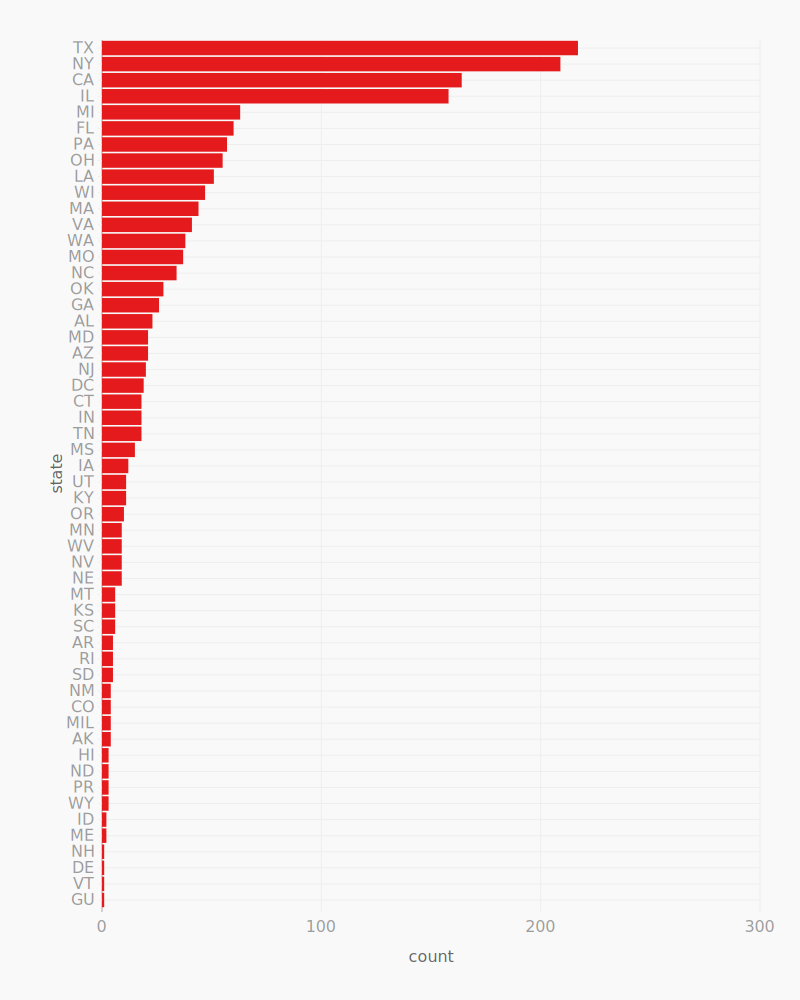

In [35]:
sorted_totals.bar_chart('state', 'count', height=1000)

Leather will try to maintain a reasonable aspect ratio for chart. In this case the chart is too short to display correctly. We've used the `height` argument to make the chart a little taller.

### Exonerations by age bracket

When creating a chart you may omit the column name arguments. If you do so the first and second columns in the table will be used. This is especially useful for charting the output of [`TableSet.aggregate`](https://agate.readthedocs.io/en/latest/api/tableset.html#agate.TableSet.aggregate) or [`Table.bins`](https://agate.readthedocs.io/en/latest/api/table.html#agate.Table.bins).

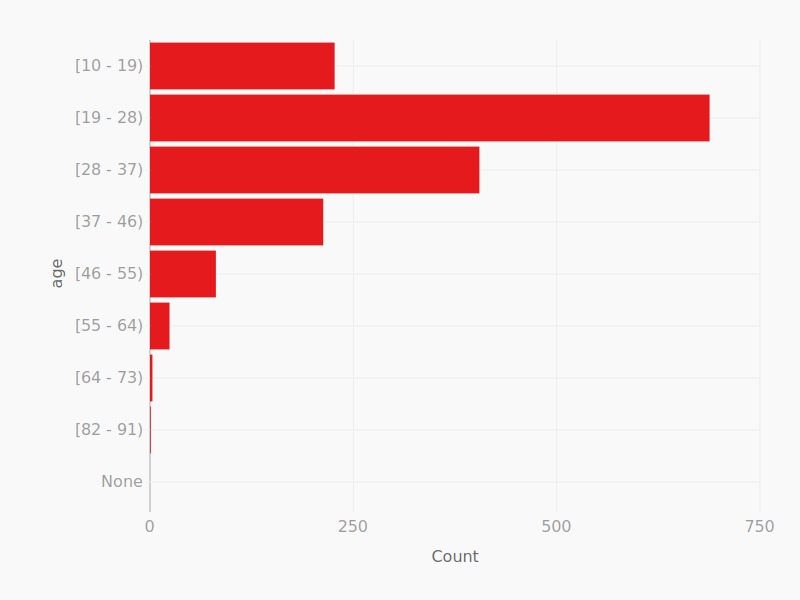

In [36]:
binned_ages.bar_chart()

### Exonerations by year

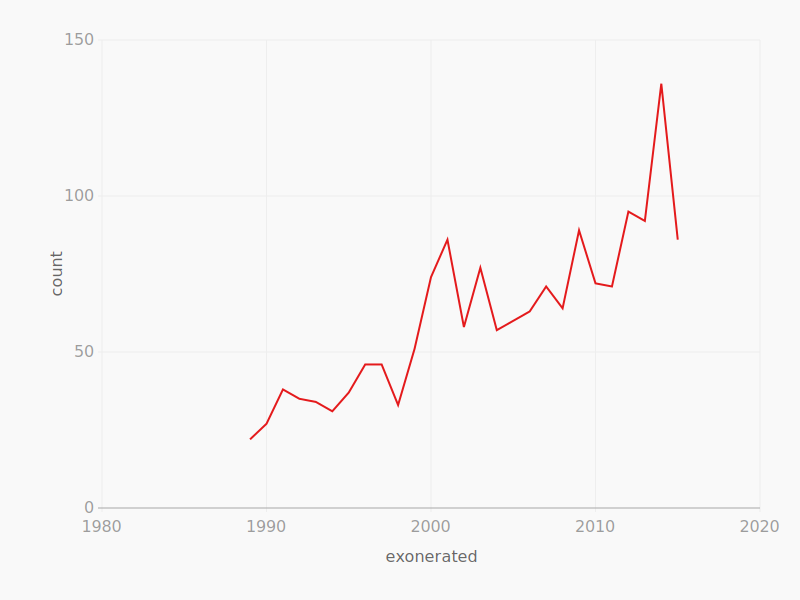

In [38]:
by_year_exonerated = exonerations.group_by('exonerated')

counts = by_year_exonerated.aggregate([
    ('count', agate.Count())
])

counts.order_by('exonerated').line_chart('exonerated', 'count')

### Exonerations over time, for most commonly exonerated crimes

The real power of agate's exploratory charting comes when we want to compare different facets of data. With leather, agate can automatically render a of chart for each group in a TableSet.

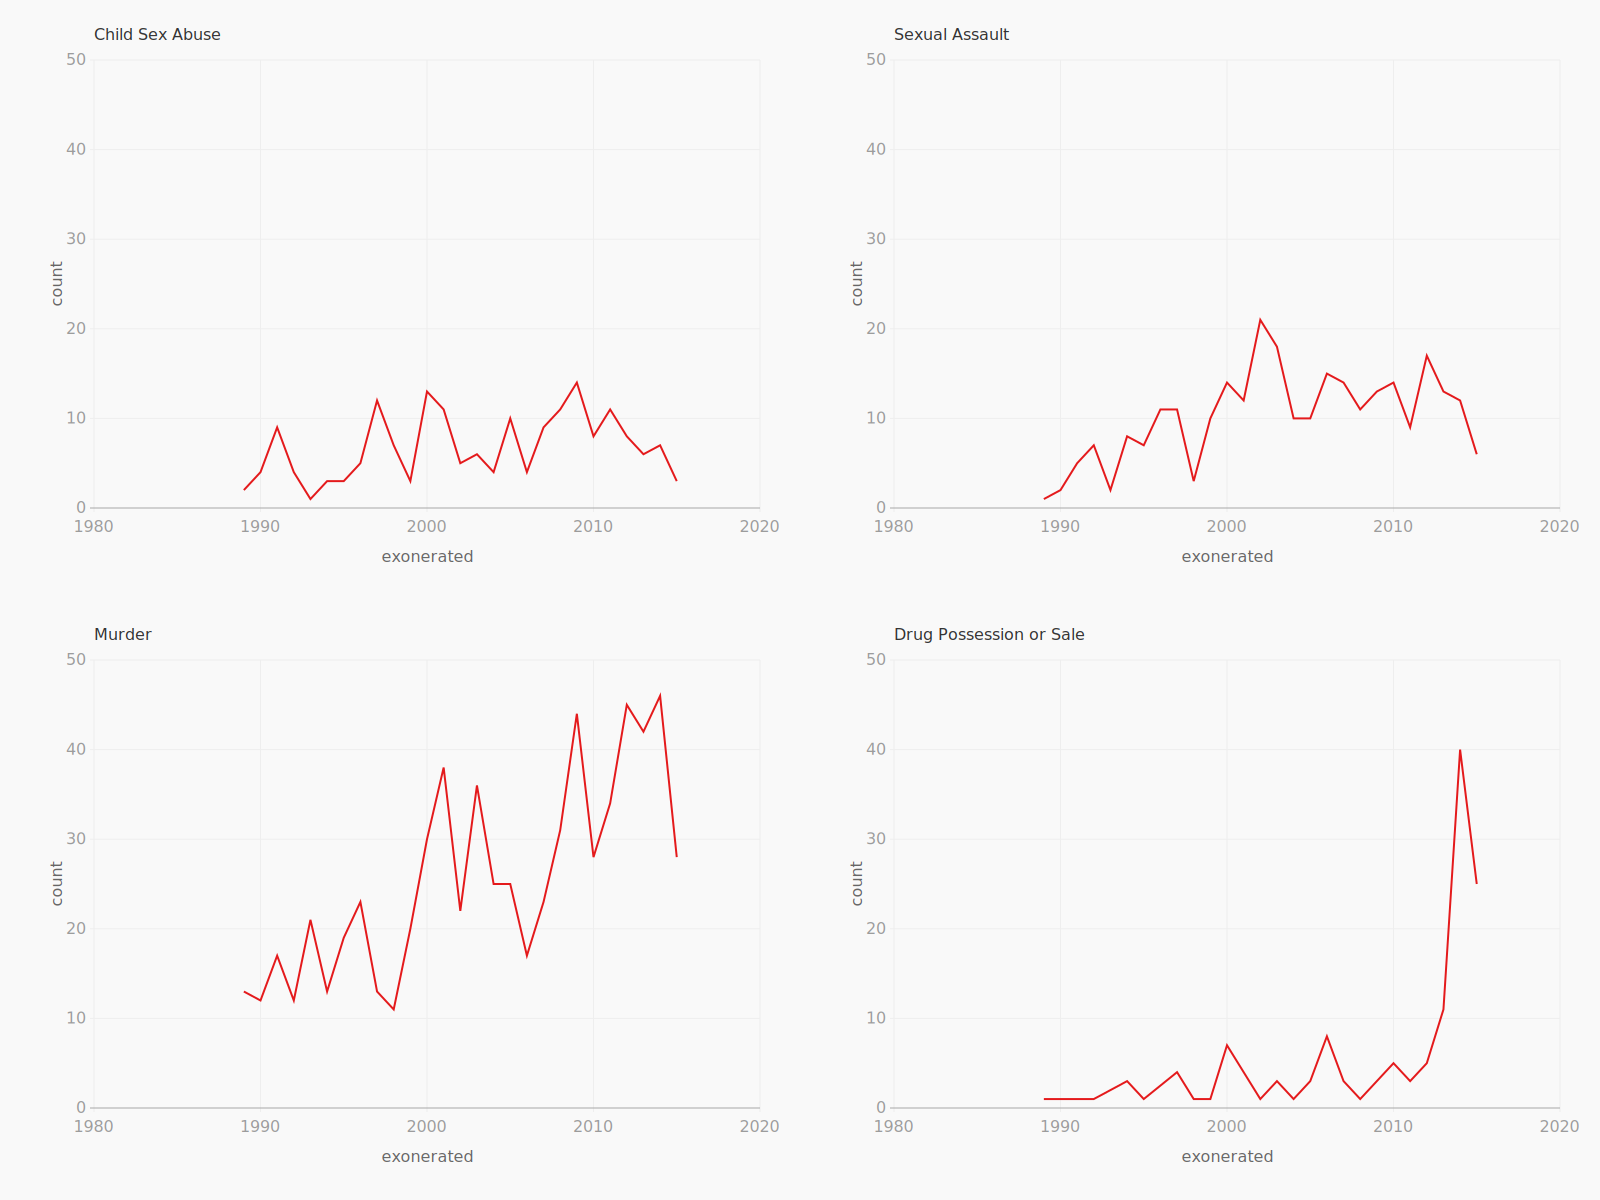

In [41]:
# Filter to crimes with at least 100 exonerations
top_crimes = exonerations.group_by('crime').having([
    ('count', agate.Count())
], lambda t: t['count'] > 100)

# Group by year of exoneration
by_year = top_crimes.group_by('exonerated')

# Count number of exonerations in each year
counts = by_year.aggregate([
    ('count', agate.Count())
])

# Group by crime
by_crime = counts.group_by('crime')

# Sort each group of exonerations by year and chart the results
by_crime.order_by('exonerated').line_chart('exonerated', 'count')

### Styling charts

As mentioned above, leather is designed for making "good enough" charts. You are never going to create a polished chart. However, sometimes you may want more control than agate offers through it's own methods. You can take more control over how your charts are presented by using [leather](https://leather.readthedocs.io/) directly.

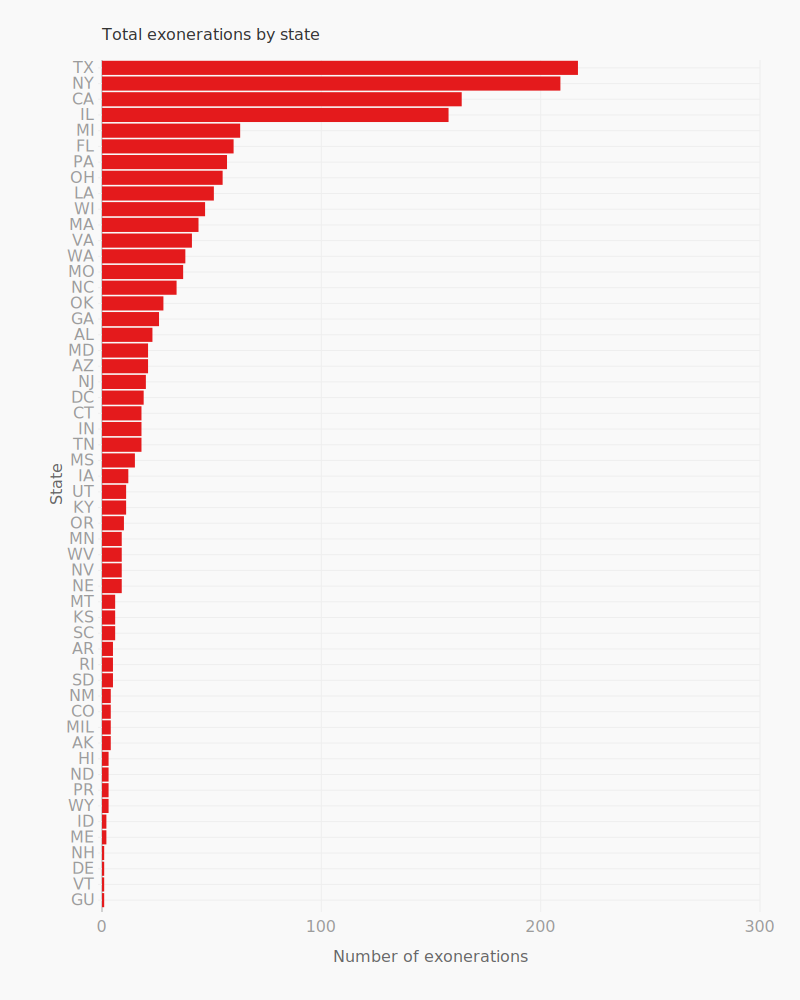

In [52]:
import leather

chart = leather.Chart('Total exonerations by state')
chart.add_y_axis(name='State')
chart.add_x_axis(name='Number of exonerations')
chart.add_bars(sorted_totals, x='count', y='state')
chart.to_svg(height=1000)

Where to go next
================

This tutorial only scratches the surface of agate's features. For many more ideas on how to apply agate, check out the [`Cookbook`](https://agate.readthedocs.io/en/latest/cookbook.html), which includes dozens of examples of specific features of agate as well as recipes for substituting agate for Excel, SQL, R and more. Also check out the agate's [`Extensions`](https://agate.readthedocs.io/en/latest/extensions.html) which add support for reading/writing SQL tables, performing statistical analysis and more.

Also, if you're going to be doing data processing in Python you really ought to check out [`proof`](https://proof.readthedocs.io/en/0.3.0/), a library for building data processing pipelines that are repeatable and self-documenting. It will make your code cleaner and save you tons of time.

Good luck in your reporting!